In [1]:
from helpers import *
from implementations import *
from preprocessing import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
#data_folder = './data/'
#data_folder = 'C:/Users/ACER/OneDrive - epfl.ch/Desktop/ML/dataset/'
data_folder = "C:/Users/plane/OneDrive/Bureau/MilaLyon/MilaLyon/data/"
#data_folder = "C:/Users/ACER/OneDrive - epfl.ch/Desktop/ML/MilaLyon/data/"

In [3]:
csv_data, zero_values, default_values = load_csv_data(data_folder, max_rows=1000000, dictionnary=True)

#Replace zeros and default values before preprocessing
replace_default_with_nan(csv_data['x_train'], csv_data['x_test'], csv_data['feature_names'], default_values)
replace_by_zero(csv_data['x_train'], csv_data['x_test'], zero_values)

def print_shapes(data):
    for key, value in data.items():
        print(f"{key}: {type(value)} with shape {value.shape if isinstance(value, np.ndarray) else 'N/A'}")
print_shapes(csv_data)


x_train: <class 'numpy.ndarray'> with shape (328135, 321)
x_test: <class 'numpy.ndarray'> with shape (109379, 321)
y_train: <class 'numpy.ndarray'> with shape (328135,)
train_ids: <class 'numpy.ndarray'> with shape (328135,)
test_ids: <class 'numpy.ndarray'> with shape (109379,)
feature_names: <class 'numpy.ndarray'> with shape (321,)
useless: <class 'numpy.ndarray'> with shape (321,)
health_related: <class 'numpy.ndarray'> with shape (321,)
better_elsewhere: <class 'numpy.ndarray'> with shape (321,)
bad_format_no_better: <class 'numpy.ndarray'> with shape (321,)
binary: <class 'numpy.ndarray'> with shape (321,)
one_hot: <class 'numpy.ndarray'> with shape (321,)


In [4]:
def preprocess_data(data, nan_drop_threshold=0.2, correlation_threshold=0.02, n_std=3, only_health_related=True, split_val=False, val_size=0.1):

    # Identify and drop features with many missing values
    nan_features = identify_too_many_missing(data["x_train"], data["feature_names"], threshold=nan_drop_threshold)
    drop_features_from_dictionnary(data, nan_features)
    print(len(nan_features), "features with too many missing values dropped.")

    # Replace remaining NaNs with either mean or most frequent value
    replace_nan(data["x_train"], data["x_test"])

    # Keep only health-related features if specified
    if only_health_related:
        non_health_features = data['feature_names'][~data['health_related']].tolist()
        drop_features_from_dictionnary(data, non_health_features)
        print(len(non_health_features), "non health-related features dropped.")

    # One-hot encode categorical features
    n_features_before = data['x_train'].shape[1]
    one_hot_encode(data)
    n_features_after = data['x_train'].shape[1]
    print(f"One-hot encoding completed. Number of features increased from {n_features_before} to {n_features_after}.")

    # Identify and drop features with low correlation to the target
    low_corr_features, _ = identify_low_correlation(data["x_train"], data["y_train"], data["feature_names"], threshold=correlation_threshold)
    drop_features_from_dictionnary(data, low_corr_features)
    print(len(low_corr_features), "features with low correlation dropped.")

    #Clip outliers
    clip_outliers(data['x_train'], data['x_test'], n_std=n_std)

    #Normalize features
    data['x_train'], data['x_test'] = min_max_normalize(data['x_train'], data['x_test'])

    data['y_train'] = (data['y_train'] == 1).astype(int)

    if split_val:
        data['x_train'], data['y_train'], data['x_val'], data['y_val'] = split_train_val(data['x_train'], data['y_train'], val_size=val_size)


In [5]:
data_copy = dict(csv_data)
preprocess_data(data_copy, nan_drop_threshold=0.9, correlation_threshold=0.01, n_std=3, only_health_related=False, split_val=True, val_size=0.1)

99 features with too many missing values dropped.
One-hot encoding completed. Number of features increased from 222 to 512.


c:\Users\plane\anaconda3\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\plane\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


214 features with low correlation dropped.
Clipped 1857812 values in x_train (1.90% of all entries)
Clipped 619390 values in x_test (1.90%)


In [6]:
print_shapes(data_copy)

x_train: <class 'numpy.ndarray'> with shape (295322, 298)
x_test: <class 'numpy.ndarray'> with shape (109379, 298)
y_train: <class 'numpy.ndarray'> with shape (295322,)
train_ids: <class 'numpy.ndarray'> with shape (328135,)
test_ids: <class 'numpy.ndarray'> with shape (109379,)
feature_names: <class 'numpy.ndarray'> with shape (298,)
useless: <class 'numpy.ndarray'> with shape (298,)
health_related: <class 'numpy.ndarray'> with shape (298,)
better_elsewhere: <class 'numpy.ndarray'> with shape (298,)
bad_format_no_better: <class 'numpy.ndarray'> with shape (298,)
binary: <class 'numpy.ndarray'> with shape (298,)
one_hot: <class 'numpy.ndarray'> with shape (298,)
x_val: <class 'numpy.ndarray'> with shape (32813, 298)
y_val: <class 'numpy.ndarray'> with shape (32813,)


In [7]:
#Logistic regression model training and evaluation
def predict_labels(tx, w, threshold=0.5):
    pred = sigmoid(tx @ w)
    return (pred >= threshold).astype(int)

dim = data_copy['x_train'].shape[1]
w, loss = logistic_regression(data_copy['y_train'], data_copy['x_train'], initial_w=np.zeros(dim), max_iters=1000, gamma=0.01)

y_pred = predict_labels(data_copy['x_val'], w)
print(compute_scores(data_copy['y_val'], y_pred))

{'accuracy': 0.9122603846036632, 'precision': 0.7647058823529411, 'recall': 0.008974801518812565, 'f1_score': 0.017741385192766974}


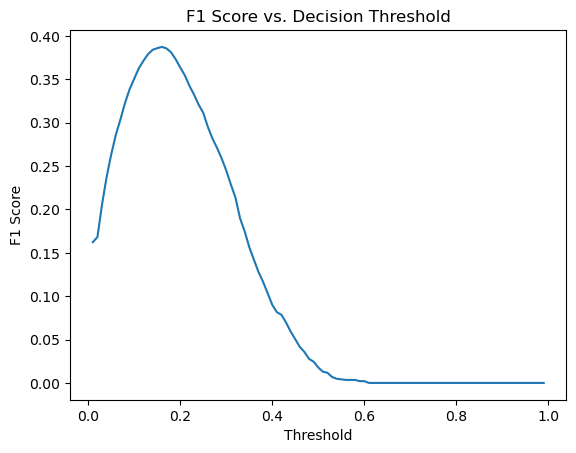

Optimal threshold based on F1 score: 0.16


In [8]:
f1s = []
for threshold in [i / 100 for i in range(1, 100)]:
    y_pred = predict_labels(data_copy['x_val'], w, threshold=threshold)
    scores = compute_scores(data_copy['y_val'], y_pred)
    f1s.append(scores['f1_score'])

plt.plot([i / 100 for i in range(1, 100)], f1s)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Decision Threshold')
plt.show()

optimal_threshold = (np.argmax(f1s) + 1) / 100
print(f"Optimal threshold based on F1 score: {optimal_threshold}")


In [9]:
test_pred = predict_labels(data_copy['x_test'], w, threshold=optimal_threshold)
#print unique values in test_pred
print("Unique values in test predictions:", np.unique(test_pred))
#Convert test_pred to 1 and -1
test_pred = np.where(test_pred == 1, 1, -1)
print("Unique values in test predictions:", np.unique(test_pred))
create_csv_submission(data_copy['test_ids'], test_pred, 'logistic_regression_submission.csv')

Unique values in test predictions: [0 1]
Unique values in test predictions: [-1  1]
